# The Heston model and pricing of forward start options

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 
import scipy.optimize as optimize

In [2]:
# set i= imaginary number
i   = np.complex(0.0,1.0)

# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\3518736085.py:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i   = np.complex(0.0,1.0)


In [15]:
def CallPutOptionPriceCOSMthd_FrwdStart(cf, CP, r, T1, T2, K, N, L):
    # cf = characteristic function as a function
    # CP = C for call and P for put
    # S0 = initial stock price
    # r  = interest rate (constant)
    # K  = list of strikes
    # N  = number of expansion terms
    # L  = size of truncation domain
    
    tau = T2 - T1
    
    # Reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K), 1])
        
    # Adjust strike for Forward Start Option
    K = K + 1
    
    # assigning imaginary number
    i  = np.complex(0, 1)
    x0 = np.log(1 / K)
    
    # Truncation domain
    a = 0 - L * np.sqrt(tau)
    b = 0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k = N - 1
    k = np.linspace(0, N-1, N).reshape([N, 1])
    u = k * np.pi / (b - a)
    
    # Determine coefficients for Put Prices
    H_k = CallPutCoefficients(CP, a, b, k)
    
    mat = np.exp(i * np.outer((x0 - a), u))
    
    temp    = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    
    value = np.exp(-r * T2) * K * np.real(mat.dot(temp))
    
    return value

In [5]:
# Determine coefficients for Put and Call Prices 
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [6]:
def BS_Call_Option_Price_FrwdStart(K, sigma, T1, T2, r):
    if K is list:
        K = np.array(K).reshape([len(K), 1])
    K = K + 1
    tau = T2 - T1
    
    d1 = (np.log(1 / K) + (r + 0.5 * np.power(sigma, 2))*tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    value = np.exp(-r * T1) * st.norm.cdf(d1) - st.norm.cdf(d2) * K *np.exp(-r * T2)
    
    return value

In [17]:
def ImpliedVolatility_FrwdStart(marketPrice, K, T1, T2, r):
    # To determine initial volatility we interpolate define a grid for sigma
    # and interpolate on the inverse
    sigmaGrid = np.linspace(0, 2, 200)
    optPriceGrid = BS_Call_Option_Price_FrwdStart(K, sigmaGrid, T1, T2, r)
    sigmaInitial = np.interp(marketPrice, optPriceGrid, sigmaGrid)
    
    print("Initial volatility = {0}".format(sigmaInitial))
    
    # Use determined input for the local-search (final tuning)
    func = lambda sigma: np.power(BS_Call_Option_Price_FrwdStart(K, sigma, T1, T2, r) - marketPrice, 1)
    # Newton Raphson optimize (scipy)
    impliedVol = optimize.newton(func, sigmaInitial, tol = 1e-15)
    print("Final volatility = {0}".format(impliedVol))
    
    return impliedVol

In [8]:
def ChFHestonModelForwardStart(r, T1, T2, kappa, gamma, vbar, v0, rho):
    # Compute the characteristic function of Heston Model for Forward Start Option
    i   = np.complex(0, 1)
    tau = T2 - T1
    
    D1 = lambda u: np.sqrt(np.power(kappa - gamma*rho*i*u,2) + (u**2 + i*u)*(gamma**2))
    g  = lambda u: (kappa - gamma*rho*i*u - D1(u)) / (kappa - gamma*rho*i*u + D1(u))
    C  = lambda u: (1 - np.exp(-D1(u)*tau)) / (gamma**2 * (1 - g(u)*np.exp(-D1(u)*tau))) * (kappa - gamma*rho*i*u - D1(u))
    
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A = lambda u: r*i*u*tau + kappa*vbar / (gamma**2) * (tau*(kappa - gamma*rho*i*u - D1(u)) - 2*np.log((1-g(u)*np.exp(-D1(u)*tau)) / (1-g(u))))
    
    c_bar = lambda t1, t2: gamma**2 / (4*kappa) * (1 - np.exp(-kappa*(t2 - t1)))
    delta = 4*kappa*vbar /(gamma**2)
    kappa_bar = lambda t1, t2: 4*kappa*v0*np.exp(-kappa*(t2 - t1)) / (gamma**2 * (1 - np.exp(-kappa*(t2 - t1))))
    
    term1 = lambda u: A(u) + C(u)*c_bar(0, T1)*kappa_bar(0, T1) / (1 - 2*C(u)*c_bar(0, T1))
    term2 = lambda u: np.power(1 / (1 - 2*C(u)*c_bar(0, T1)), 0.5*delta)
    
    cf = lambda u: np.exp(term1(u)) * term2(u)
    
    return cf

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\2209900658.py:3: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i   = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\1126044887.py:20: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i  = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\Ap

Initial volatility = [0.31192467]
Final volatility = [0.3119319]
Initial volatility = [0.30208092]
Final volatility = [0.30208715]
Initial volatility = [0.29359471]
Final volatility = [0.29360364]
Initial volatility = [0.28631279]
Final volatility = [0.28631625]
Initial volatility = [0.28011355]
Final volatility = [0.28011299]
Initial volatility = [0.27490873]
Final volatility = [0.27490777]
Initial volatility = [0.27062136]
Final volatility = [0.27062241]
Initial volatility = [0.26716387]
Final volatility = [0.26717596]
Initial volatility = [0.26445985]
Final volatility = [0.2644806]
Initial volatility = [0.26242763]
Final volatility = [0.26244284]
Initial volatility = [0.26096025]
Final volatility = [0.26096793]
Initial volatility = [0.25992889]
Final volatility = [0.25996498]
Initial volatility = [0.25928935]
Final volatility = [0.25935099]
Initial volatility = [0.2589699]
Final volatility = [0.2590532]
Initial volatility = [0.25890957]
Final volatility = [0.25900971]
Initial volati

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\2209900658.py:3: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i   = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\1126044887.py:20: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i  = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\Ap

Final volatility = [0.29070075]
Initial volatility = [0.29166296]
Final volatility = [0.29168741]
Initial volatility = [0.29254909]
Final volatility = [0.29267216]
Initial volatility = [0.29344323]
Final volatility = [0.29365219]
Initial volatility = [0.2943466]
Final volatility = [0.29462537]
Initial volatility = [0.29526063]
Final volatility = [0.2955899]
Initial volatility = [0.29618715]
Final volatility = [0.29654456]
Initial volatility = [0.297128]
Final volatility = [0.29748827]
Initial volatility = [0.29808517]
Final volatility = [0.29842017]
Initial volatility = [0.29906101]
Final volatility = [0.29933988]
Initial volatility = [0.30005775]
Final volatility = [0.30024695]
Initial volatility = [0.30107767]
Final volatility = [0.30114102]
Initial volatility = [0.30194558]
Final volatility = [0.30202189]
Initial volatility = [0.30269599]
Final volatility = [0.30288961]
Initial volatility = [0.30345102]
Final volatility = [0.30374423]
Initial volatility = [0.30421226]
Final volatili

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\2209900658.py:3: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i   = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\1126044887.py:20: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i  = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\Ap

Initial volatility = [0.25983505]
Final volatility = [0.25993543]
Initial volatility = [0.26040901]
Final volatility = [0.26048079]
Initial volatility = [0.26108208]
Final volatility = [0.261103]
Initial volatility = [0.2617391]
Final volatility = [0.26178434]
Initial volatility = [0.26239618]
Final volatility = [0.26251065]
Initial volatility = [0.26308611]
Final volatility = [0.26327056]
Initial volatility = [0.26380421]
Final volatility = [0.26405501]
Initial volatility = [0.26454754]
Final volatility = [0.26485668]
Initial volatility = [0.26531457]
Final volatility = [0.26566976]
Initial volatility = [0.2661047]
Final volatility = [0.26648946]
Initial volatility = [0.26691832]
Final volatility = [0.2673121]
Initial volatility = [0.26775635]
Final volatility = [0.26813464]
Initial volatility = [0.26862033]
Final volatility = [0.26895474]
Initial volatility = [0.26951193]
Final volatility = [0.26977026]
Initial volatility = [0.27043369]
Final volatility = [0.27057995]
Initial volatil

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\2209900658.py:3: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i   = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_27584\1126044887.py:20: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i  = np.complex(0, 1)
C:\Users\NGUYEN Xuan Vinh\Ap

Final volatility = [0.27781756]
Initial volatility = [0.27533907]
Final volatility = [0.27534671]
Initial volatility = [0.27316587]
Final volatility = [0.2731743]
Initial volatility = [0.27126368]
Final volatility = [0.27126454]
Initial volatility = [0.26956817]
Final volatility = [0.26958674]
Initial volatility = [0.268078]
Final volatility = [0.26811396]
Initial volatility = [0.26677269]
Final volatility = [0.26682297]
Initial volatility = [0.26563366]
Final volatility = [0.26569345]
Initial volatility = [0.26464342]
Final volatility = [0.26470705]
Initial volatility = [0.26378614]
Final volatility = [0.26384777]
Initial volatility = [0.26304767]
Final volatility = [0.26310179]
Initial volatility = [0.26241447]
Final volatility = [0.26245619]
Initial volatility = [0.26187478]
Final volatility = [0.26190006]
Initial volatility = [0.26141803]
Final volatility = [0.26142377]
Initial volatility = [0.26100213]
Final volatility = [0.26101904]
Initial volatility = [0.26063802]
Final volatil

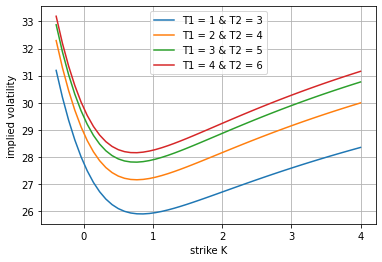

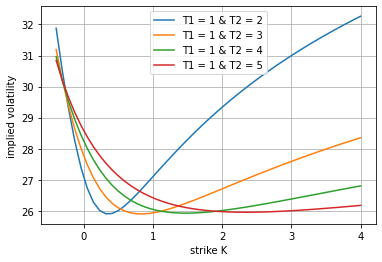

In [18]:
def mainCalculation():
    CP = OptionType.CALL
    r  = 0
    
    # T1 = 1, 2, 3, 4 and T2 = T1 + 2
    TMat1 = [[1, 3], [2, 4], [3, 5], [4, 6]]
    # T1 = 1 and T2 = 2,3,4,5
    TMat2 = [[1, 2], [1, 3], [1, 4], [1, 5]]
    
    K = np.linspace(-0.4, 4, 50)
    K = np.array(K).reshape(len(K), 1)
    
    N = 500
    L = 10
    
    # Heston model parameters
    kappa = 0.6
    gamma = 0.2
    vbar  = 0.1
    rho   = -0.5
    v0    = 0.05
    
    plt.figure(1)
    plt.grid()
    plt.xlabel('strike K')
    plt.ylabel('implied volatility')
    legend = []
    
    for T_pair in TMat1:
        T1 = T_pair[0]
        T2 = T_pair[1]
        cf = ChFHestonModelForwardStart(r, T1, T2, kappa, gamma, vbar, v0, rho)
        
        # Forward Start Option from the COS method
        valCOS = CallPutOptionPriceCOSMthd_FrwdStart(cf, CP, r, T1, T2, K, N, L)
        
        # Implied volatilities
        IV = np.zeros([len(K), 1])
        for idx in range(0, len(K)):
            IV[idx] = ImpliedVolatility_FrwdStart(valCOS[idx], K[idx], T1, T2, r)
        plt.plot(K, IV*100)
        legend.append('T1 = {0} & T2 = {1}'.format(T1, T2))
    plt.legend(legend)
    
    plt.figure(2)
    plt.grid()
    plt.xlabel('strike K')
    plt.ylabel('implied volatility')
    legend = []
    
    for T_pair in TMat2:
        T1 = T_pair[0]
        T2 = T_pair[1]
        cf = ChFHestonModelForwardStart(r, T1, T2, kappa, gamma, vbar, v0, rho)
        
        # Forward Start Option from the COS method
        valCOS = CallPutOptionPriceCOSMthd_FrwdStart(cf, CP, r, T1, T2, K, N, L)
        
        # Implied volatilities
        IV = np.zeros([len(K), 1])
        for idx in range(0, len(K)):
            IV[idx] = ImpliedVolatility_FrwdStart(valCOS[idx], K[idx], T1, T2, r)
        plt.plot(K, IV*100)
        legend.append('T1 = {0} & T2 = {1}'.format(T1, T2))
    plt.legend(legend)
    
mainCalculation()

When we fix interval of time and move in time T1, we have same shape of smile, as long as we move away from T0, we have convergence to sqrt(vbar).  

When we fix initial T1 and expand maturity, we have sharp smile for short maturity and flattener smile for long maturity